## Programming Exercise 5: Regularized Linear Regression and Bias vs. Variance

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.optimize #fmin_cg to train the linear regression

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (8, 5) # set default size of plots

### 1 Regularized Linear Regression

#### 1.1 load the dataset

In [4]:
# 데이터 불러오기
datafile = 'data/ex5data1.mat'
mat = scipy.io.loadmat( datafile )
X = np.concatenate([mat['X'], mat['Xval'], mat['Xtest']], axis=0)
y = np.concatenate([mat['y'], mat['yval'], mat['ytest']], axis=0)

X의 shape 는 (54, 1)
y의 shape 는 (54, 1)


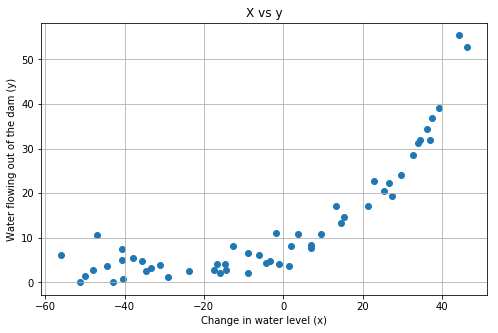

In [5]:
# X, y의 shape를 확인해보고 그래프로 어떻게 나타나는지 그려보자.

### 코드 시작 ###
# 1. X, y shape 확인 
print('X의 shape 는',X.shape)
print('y의 shape 는',y.shape)

# 2. 아래 그래프 그리는 함수 완성 후 실행. 
def plot(X, y):
    """
    X: X 데이터 (array)
    y: y 데이터 (array)
    """
    plt.scatter(X, y)
    plt.grid()
    plt.title('X vs y')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')

plot(X, y)

#### Train/Val/Test 데이터 나누기
X, y에 대한 총 데이터를 6:2:2의 비율로 나눠서 train/val/test 데이터로 명명해준다. 여기서 데이터가 random하게 섞여있을 지 아닐 지 모르므로 처음에 random하게 섞어주는게 중요하다.

In [7]:
def data_split(X, y):
    # X, y의 index는 서로 매칭되므로 index를 random하게 섞어서 6:2:2의 개수만큼 배분해주자.
    # 1. np.random.choice 활용, replace라는 인수가 있을텐데 비복원/복원 추출에 대한 얘기이다.
    
    random_indices = np.random.choice(X.shape[0], size = X.shape[0], replace = False)

    # train/val/test 데이터의 개수를 지정하자. (6:2:2)
    num_train = int(X.shape[0] * 0.6)
    num_val = int(X.shape[0] * 0.2)
    num_test = int(X.shape[0] - num_train - num_val)

    # 지정된 개수만큼 배분해주자.
    X_train = X[ : num_train]
    X_val = X[num_train : num_train + num_val]
    X_test = X[num_train + num_val : ]
    y_train = y[ : num_train]
    y_val = y[num_train : num_train + num_val]
    y_test = y[num_train + num_val : ]
    
    # 각각의 데이터에 bias를 더해준다. 
    X_train = np.insert(X_train, 0, 1, axis = 1)
    X_val = np.insert(X_val, 0, 1, axis = 1)
    X_test = np.insert(X_test, 0, 1, axis = 1)
    
    # X, y train/val/test 모두 반환해주자. 
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y)

In [13]:
X_train[:,1].shape

(32,)

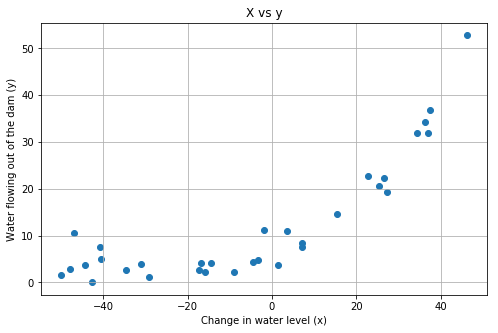

In [14]:
# train으로 뽑은 값들을 그려보자. 
# 그래프를 그려보면 값이 몇 개 듬성듬성 빠지긴 했지만 전체적인 그래프 모양은 비슷하다.
# 위에서 정의한 함수를 이용해서 아래에 그래프를 그리자! bias 조심

plot(X_train[:, 1], y_train)

#### 1.2 Regularized linear regression cost function

계속 하던 $h$ 식과 cost 식의 구현이다. 지금까지 많이했으니 넘어가도록 하자.

In [15]:
# hypothetis(h) 식 구현
def h(theta,X): 
    return np.dot(X,theta)

# Cost function 구현
def computeCost(theta,X,y,lambda_param=0.): #Cost function
    """
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    y is a matrix with m- rows and 1 column
    """
    m = X.shape[0]
    cost = float((1./(2*m)) * np.sum(np.square(h(theta, X) - y)))
    cost_reg = (float(lambda_param)/(2*m)) * float(np.sum(np.square(theta[1:])))
    return cost + cost_reg

In [16]:
# theta 값이 [[1.], [1.]]일 때 cost를 구해보자. 
theta = np.array([[1.],[1.]])
print(computeCost(theta, X_train, y_train, lambda_param=1.))

340.09509447710894


#### 1.3 Regularized linear regression gradient

Gradient를 구한다. 

In [17]:
def computeGradient(theta, X, y, lambda_param=0.):
    m = X.shape[0]
    grad = (1./float(m)) * np.dot(X.T, (h(theta, X) - y))
    grad_reg = (float(lambda_param) / m) * theta
    grad_reg[0] = 0
    return grad + grad_reg

In [18]:
def computeGradient(theta,X,y,lambda_param=0.):
    m = X.shape[0]
    #grad has same shape as myTheta (2x1)
    h_x = h(theta, X)
    grad = (1./float(m))*np.dot(X.T, (h_x - y))
    grad_reg = (float(lambda_param)/m)*theta
    grad_reg[0] = 0 #don't regulate bias term
    grad_reg.reshape((grad.shape[0],1))
    return grad + grad_reg

In [20]:
# Using theta initialized at [1; 1] you should expect to see a
# gradient of [-15.303016; 598.250744] (with lambda=1)
theta = np.array([[1.],[1.]])
print(computeGradient(theta, X_train, y_train, 1.))

[[ -16.38365446]
 [ 642.51366477]]


#### 1.4 Fitting linear regression

optimize 한다.

In [21]:
def optimize(initial_theta, X, y, lambda_param=0., num_iterations=2000, learning_rate=0.001):
    theta = initial_theta
    cost_history = []
    for i in range(num_iterations):
        cost = computeCost(theta, X, y, lambda_param)
        cost_history.append(cost)
        dtheta = computeGradient(theta, X, y, lambda_param)
        theta -= learning_rate * dtheta
    return theta, cost_history

In [22]:
initial_theta = np.array([[1.], [1.]])
trained_theta, cost_history = optimize(initial_theta, X_train, y_train, 0)

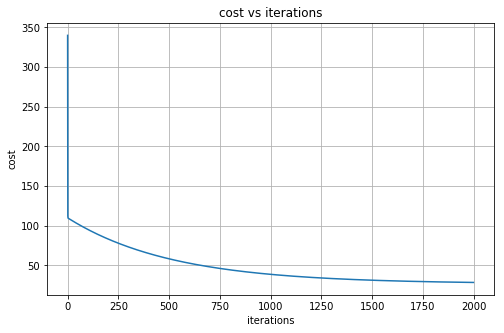

In [23]:
# cost history를 그래프로 나타내는 함수를 구현하자. 조금만 수정하면 된다. 
def plot_cost_history(cost_history):
    """
    cost_history: optimize시 진행된 cost 이력
    """
    plt.plot(cost_history)
    plt.grid()
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title('cost vs iterations')
    plt.show()
plot_cost_history(cost_history)

우리가 구한 theta가 모델을 얼마나 잘 나타내는지 확인해보자. <br>
--> 위에서 본 그래프에 우리가 구한 모델을 그리면 얼마나 괜찮은지 눈으로 확인할 수 있다.

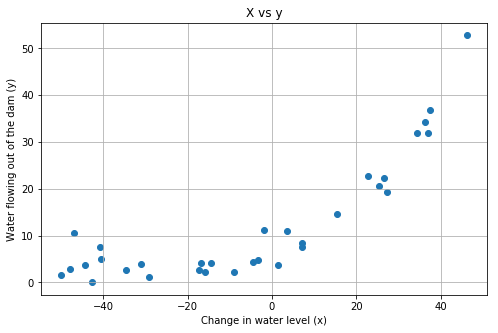

In [30]:
# 먼저, 위에서 본 X_train 그래프를 그리자. 
plot(X_train[:, 1], y_train)

##### linspace 에서 '10'과 '100'의 차이점이 없다 #####
##### 왜 x를 reshape 해야 하는지? ######

# x축의 값을 나타내자 np.linspace 활용. 
x = np.linspace(-60, 60, 10)
'''x = np.linspace(-60, 60, 100)'''
# x의 shape을 바꿔주자. 
x = np.reshape(x, [-1, 1])
# x에 bias 추가하자. 
x = np.insert(x, 0, 1, axis = 1)
# h를 구하고 그래프를 그린다. (x, h)인 그래프이며 위 그래프와 겹쳐진다. 
plt.plot()
plt.show()

### 2 Bias-variance

#### 2.1 Learning curves

데이터의 개수에 따라 변하는 train/validation error를 살펴보도록 하자. 

In [31]:
theta = np.array([[1.],[1.]])
print(theta.shape)

(2, 1)


In [32]:
def plot_learningcurve():
    
    # learning curve를 그려보자. 
    # 방법은 X_train의 개수를 변화시키면서 학습을 시켜보고 결과를 그래프로 나타내본다. 
    
    # 1. train 데이터 개수를 변수에 저장한다. 
    num_train = num_train = int(X.shape[0] * 0.6)
    # 2. initial_theta 값을 선언한다. 
    initial_theta = np.array([[1.], [1.]])
    # 3. 그래프 그릴 때 변수들을 저장할 공간을 만든다. m(데이터 개수), train_error, val_error 
    m, train_error, val_error = [], [], []
    # 4. for문을 통해서 train 데이터 개수 변화시키면서 train/val error를 구하자. 
    
    ##### 아래 코딩은 이해가 안됨.... 설명 필요요 ######
    ##### 그리고 어느정도 예시를 쓰면서 확인은 하고 있긴 하다만 #####
    ##### [:,:] 이거에 대해서 간략하게 설명해줬으면 함 #####
    
    for x in range(1,num_train):
        ### 4번 내용 (약 4~6줄) ### 
        train_subset = X_train[:x,:]
        y_subset = y_train[:x]
        m.append(y_subset.shape[0])
        trained_theta, _ = optimize(initial_theta, train_subset, y_subset, lambda_param=0.)
        train_error.append(computeCost(trained_theta, train_subset, y_subset, lambda_param=0.))
        val_error.append(computeCost(trained_theta, X_val, y_val,lambda_param=0.))
        
    # 5. 그래프를 그리자. 
    plt.figure(figsize=(8,5))
    plt.plot(m, train_error, label = 'train') # m에 따른 train_error 그래프를 그려야 한다. 
    plt.plot(m, val_error, label = 'val') # m에 따른 val_error 그래프를 그리자. 
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.grid(True)

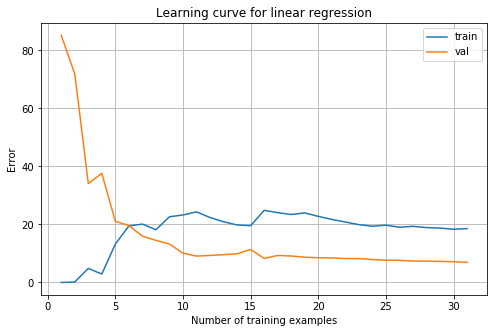

In [33]:
# 위에서 작성한 함수 실행 
plot_learningcurve()

### 3 Polynomial regression

여태까지 본 hypothesis 식: $h = \theta \cdot X$

위 식을 변형해서 복잡한 그래프 나타내자: $h = \theta \cdot X_1 + \theta \cdot X_1^2 + ... +\ \theta \cdot X_1^n$

**Q. polynomial graph로 나타내기 위해서는 normalization이 필수적이다. 왜 그럴까?**<br>
**A : 그러게 왜 그러는 거니...? Linear Regression with multiple variables에서 mean normalization을 했던거 같은데..**

In [34]:
# X 값을 normalization 시키자. 
def normalization(x):
    return (x - x.mean()) / x.std()

In [35]:
# normalization을 적용한다. 
normed_X = normalization(X)
# train/val/test 데이터를 만든다. (위 normed_X 활용) 
X_train, X_val, X_test, y_train, y_val, y_test = data_split(normed_X, y)

위와 마찬가지로 그래프로 나타내보자. 

In [38]:
print(X_train.shape)
print(X_train[:, 1].shape)
print(X_train[0, :].shape)

(32, 2)
(32,)
(2,)


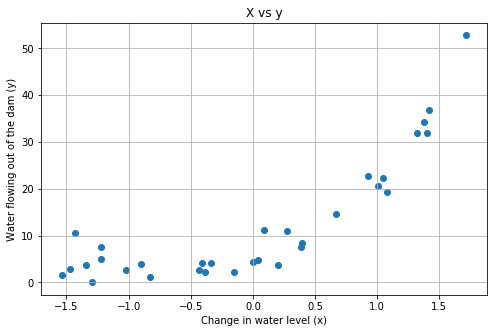

In [39]:
# X_train, y_train 값 그래프로 나타내보자. 
plot(X_train[:, 1], y_train)

$h$ 식을 변경할 예정이므로 그에 맞게 $X, \theta$도 바꿔줘야 한다. $X$에는 다차원의 항이 들어가고 동일한 데이터를 사용한다. 
$\theta$는 차수(degree)에 맞춰서 차원이 증가한다.<br> 
여태까지 본 hypothesis 식: $h = \theta \cdot X$

위 식을 변형해서 복잡한 그래프 나타내자: $h = \theta \cdot X_1 + \theta \cdot X_1^2 + ... +\ \theta \cdot X_1^n$

In [43]:
# 먼저, 3차원으로 해보자.
degree = 3

# 다차 함수 구현에 따른 raw 입력 데이터 변경이 필요하다. X를 같은 값으로 사용하니까 단순히 n승을 해준 뒤 concat해주면 된다. 
def add_polynomial_value(X, degree):
    """
    X: 값을 변화시켜줄 X값
    degree: 차수
    """
    ##### 밑에 코드는 정확히 어떤 의미인가요 #####
    # 차수에 맞는 값들을 list에 넣는다.
    add_values = [np.reshape(X[:, 1]**i, [-1, 1]) for i in range(2, degree + 1)]
    # 이전 값(X)와 더해줄 값을 concat한다. (np.concatenate)
    ##### np.concatenate((X, add_values), axis = 1) 이렇게 하면 안되는지?? #####
    return np.concatenate([X] + add_values, axis = 1)

In [44]:
# train/val/test 모두 데이터 변경해준다. 
normed_X_train = add_polynomial_value(X_train, degree)
normed_X_val = add_polynomial_value(X_val, degree)
normed_X_test = add_polynomial_value(X_test, degree)

h, cost를 구하는 식은 1차원일 때와 동일하다 진행하면 된다. 변경된 $\theta, X$만 잘 입력해주자 <br>
**Q. 왜 h, cost 구하는 식을 동일하게 써도 문제가 없을까?**<br>
**A : 그거야 X나 theta가 matrix니까 그러지 않습니까 **

In [45]:
# cost가 잘 구해지는 지 확인해보자.
# 초기 theta만 지정해서 넣어주자. 
# np.ones를 사용하고 shape를 뭘 쓸지 생각해보자.
theta = np.ones([normed_X_train.shape[1], 1])
print(theta)
print(theta.shape)
print(normed_X_train.shape)
print(computeCost(theta, normed_X_train, y_train, lambda_param=1.))

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
(4, 1)
(32, 4)
103.83870432841715


In [46]:
# gradient를 구해보자. 값을 확인해서 너무 크거나 너무 작은 값이 없는지 보자. 
print(computeGradient(theta, normed_X_train, y_train, 1.))

[[-10.29688421]
 [ -7.58199492]
 [-15.16394136]
 [-14.53339636]]


In [48]:
# optimiize해서 잘 되는지 확인해보자.
# 초기 theta값을 지정해주자. 
initial_theta = theta
trained_theta, cost_history = optimize(initial_theta, normed_X_train, y_train)

In [49]:
print(theta.shape)
print(theta.shape[0])

(4, 1)
4


In [51]:
# 예측 값을 구해보자. 
# 다차 함수이므로 x값은 1개 값이 주어졌을 때 theta*x^2 + theta*x^3.. 를 구해야한다. 
def prediction(theta, x):
    """
    theta: 학습한 theta (array)
    x: 예측할 x값 (array)
    """
    # 방법은 degree 수에 따라서 theta + theta*x^2 + ... theta*x^n을 하는 방식을 취할 것이다. for문을 돌려서 구하자. 
    # degree는 theta로부터 얻을 수 있다. 
    degree = theta.shape[0] - 1
    # pred가 우리가 구하려는 값이다. (최종 값 scalar)
    pred = 0
    # 위에 내용을 for문으로 구현하자.
    for i in range(0, degree + 1):
        pred += theta[i] * (x**i)
    return pred

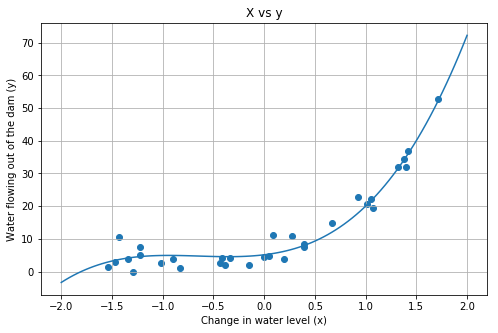

In [52]:
# polynomial 구한 값을 그래프로 나타내자. 
def plot_polynomial(trained_theta):
    # x축 값을 지정해주자. (np.linspace)
    x = np.linspace(-2, 2, 100)
    # 예측 값을 구하자. 
    pred = prediction(trained_theta, x)
    # 그래프를 그려주자. 
    plt.plot(x, pred)
    plt.show()
    
# 점만 그려진 그래프를 그리고 그 위에 덮어서 여기서 구현한 함수로 그래프를 그리자. 
plot(X_train[:, 1], y_train)
plot_polynomial(trained_theta)

In [54]:
# degree에 따라서 어떻게 error가 변할지 살펴보자. 
def plot_dimensioncurve(degree, lambda_param=0.):
    """
    degree: n차 함수의 n값 (int)
    lambda_param: regularizer의 lambda값 (float)
    """ 
    
    # 위에서 그린 learning curve와 다른 점은 degree에 대해서로 변한 점 밖에 없다. 나머지 로직은 동일 
    # 1. degrees, train_error, val_error 받을 저장 공간을 만든다. 
    degrees, train_error, val_error = [], [], []
    # 2. for문을 통해서 degree를 변화시키면서 train/val error를 구하자. (약 4~6줄)
    ##### 위에와 똑같이 이건 잘 모르겠습니다 #####
    for d in range(1, degree + 1):
        
        degrees.append(d)
        # initial theta 지정
        initial_theta = np.ones([d + 1, 1])
        # degree에 따른 X 구하기
        normed_X_train = add_polynomial_value(X_train, d)
        normed_X_val = add_polynomial_value(X_val, d)
        # theta 구하기
        trained_theta, _ = optimize(initial_theta, normed_X_train, y_train, lambda_param=lambda_param)
        train_error.append(computeCost(trained_theta, normed_X_train, y_train, lambda_param=lambda_param))
        val_error.append(computeCost(trained_theta, normed_X_val, y_val, lambda_param=lambda_param))
        
        
    # 3. 그래프를 그리자.     
    plt.figure(figsize=(8,5))
    plt.plot(degrees, train_error, label='Train') # degree에 따른 train_error 그래프를 그려야 한다.
    plt.plot(degrees, val_error, label='Cross Validation') # degree에 따른 val_error 그래프를 그려야 한다. 
    plt.legend()
    plt.title('Dimension curve for polynomial regression')
    plt.xlabel('Number of degrees')
    plt.ylabel('Error')
    plt.grid(True)

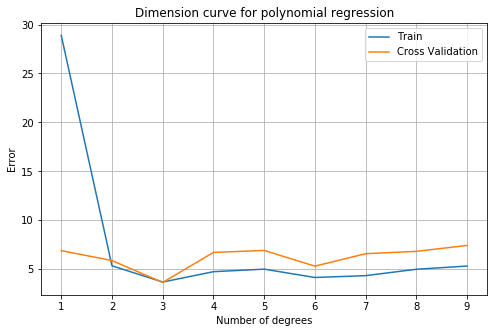

In [55]:
plot_dimensioncurve(10)

위에서 어떤 결과일 때 가장 성능이 좋은가? 그 그래프를 그려보자.

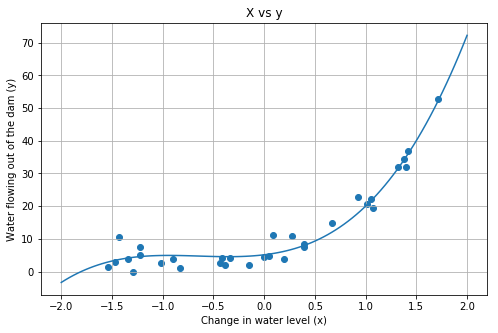

In [56]:
# 자유롭게 위에 내용으로 가장 성능이 괜찮은 그래프를 나타내자. 
# degree가 변하면 몇몇 값들을 다시 지정해주어야 하고 변하지 않았으면 1줄로 구현 가능하다.
plot(X_train[:, 1], y_train)
plot_polynomial(trained_theta)

## 4. regularizer

lambda에 따라서 어떻게 변하는 지 확인해보자.

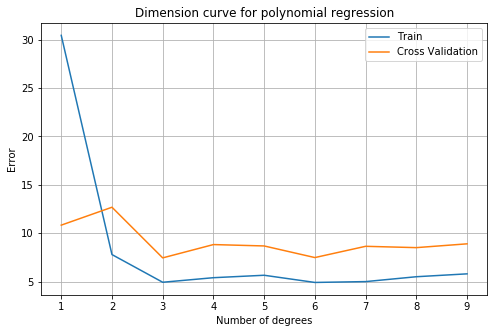

In [57]:
# lambda를 변화시키면서 그래프가 어떻게 되는지 보자.
plot_dimensioncurve(degree=10, lambda_param=1)

In [58]:
def plot_lambdacurve(degree):
    lambdas, train_error, val_error = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.], [], []
    for l in lambdas:
        ##### 위의 이해 안되는 것과 같음 #####
        # initial theta 지정
        initial_theta = np.ones([degree + 1, 1])
        # degree에 따른 X 구하기
        normed_X_train = add_polynomial_value(X_train, degree)
        normed_X_val = add_polynomial_value(X_val, degree)
        # theta 구하기
        trained_theta, _ = optimize(initial_theta, normed_X_train, y_train, lambda_param=l)
        train_error.append(computeCost(trained_theta, normed_X_train, y_train, lambda_param=l))
        val_error.append(computeCost(trained_theta, normed_X_val, y_val, lambda_param=l))
        
    plt.figure(figsize=(8,5))
    plt.plot(lambdas, train_error, label='Train')
    plt.plot(lambdas, val_error, label='Cross Validation')
    plt.legend()
    plt.title('lambda curve for polynomial regression')
    plt.xlabel('lambda value')
    plt.ylabel('Error')
    plt.grid(True)

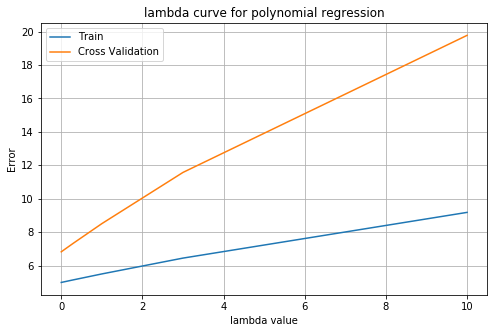

In [59]:
plot_lambdacurve(8)